In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [2]:
execfile(r'C:\Users\adrag\Desktop\Master Data Science UCM\Módulo minería de datos 1\NuestrasFunciones.py')

# Objetive: 
### This dataset has the mean consumption of each month for the last 15 years until April 2024, for this exercise we are going to predict the consumption by month for the rest of the year and bring some insights.

# Step 1: Read data and make proper changes

### As a first approach to the data we will read it, check null values and correct dtypes

In [3]:
electricity = pd.read_csv("Uk_national_demand.csv")

In [4]:
electricity

,settlement_date,nd
0,2009-01-01,42499.286962
1,2009-02-01,41721.263393
2,2009-03-01,38034.520188
3,2009-04-01,34244.037500
4,2009-05-01,32551.792339
...,...,...
179,2023-12-01,29538.508737
180,2024-01-01,31808.836022
181,2024-02-01,29526.081897
182,2024-03-01,27902.240242


In [5]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   settlement_date  184 non-null    object 
 1   nd               184 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


### Great, no null values, lets change the dtype to datetime

In [6]:
electricity["settlement_date"] = pd.to_datetime(electricity["settlement_date"])

In [7]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   settlement_date  184 non-null    datetime64[ns]
 1   nd               184 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


# Step 2: Exploratory Data Analysis

### For this EDA we are going to plot the national demand over the time, it will help us with an overview of this time serie

C:\Users\adrag\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adrag\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='settlement_date', ylabel='nd'>

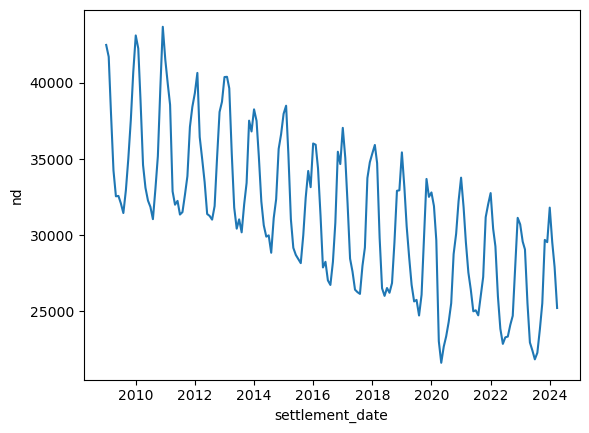

In [8]:
sns.lineplot(data = electricity, x = "settlement_date", y = "nd")

### It looks like this serie has no obvious outliers, maybe 2020 with the pandemic the consumption dropped down, which is normal. It also seem to have some descend trend over the time. Appart from that it's visible some kind of seasoning, let's decompose to better understand this time serie. Talking about heterocedasticity it doesn't have, or at least it is not obvious with this plot

### As a next step we will decompose this time serie, it will help us identifying better the characteristics

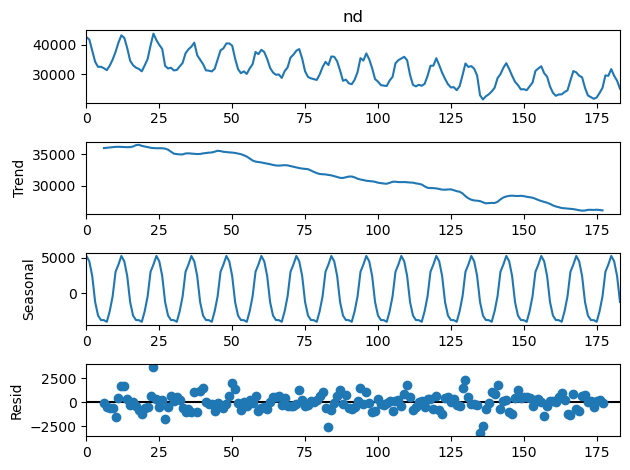

In [9]:
# Lets apply additive decompose as the seasonal variability looks constant over the years (No heterocedasticity)
decompose = seasonal_decompose(electricity["nd"], model='additive',period=12)
decompose.plot()
plt.show()

### As a conclussion, its clear the trend and the seasonal characteristic of this time serie. Resids looks incorrelated, with 0 mean, which is great, because that means that if we control the trend and seasonality we could have a stationary serie, which is needed for ARIMA approaches. We will later use an stadistic test to be sure
### Appart from that, no heterocedasticity is observed, but we will use the log transformation to check, just to see.

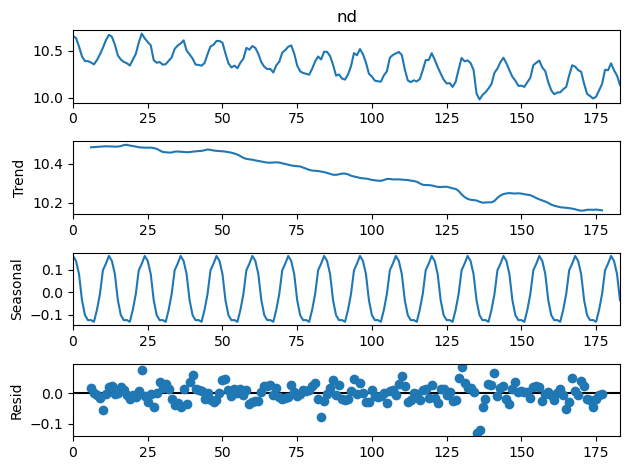

In [10]:
decompose_log = seasonal_decompose(np.log(electricity["nd"]), model='additive',period=12)
decompose_log.plot()
plt.show()

### Resids looks also incorrelated, it seems that also with the logaritmic transformation the serie can be stationary

### As said before, we could have a potential stationary serie if we control Trend and Seasonality, but we will apply the test Dickey-Fuller to the resids of both decomposotitions to be sure.
### This test means that if the p-value is under 0.05, it will mean that if we remove trend and seasonality, we will have an stationary serie.

In [11]:
print('Results of Dickey-Fuller Test of the resids for the original decompose:')
dftest = adfuller(decompose.resid.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Results of Dickey-Fuller Test of the resids for the original decompose:
Test Statistic   -8.851908e+00
p-value           1.564682e-14
dtype: float64


In [12]:
print('Results of Dickey-Fuller Test of the resids for the logaritmic decompose:')
dftest = adfuller(decompose_log.resid.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Results of Dickey-Fuller Test of the resids for the logaritmic decompose:
Test Statistic   -6.666635e+00
p-value           4.699668e-09
dtype: float64


### In both cases p-value is under 0.05, which means we accept H1 and resids have no trend of any kind

### After this evaluation we can be sure in both cases that if we remove trend and seasonality we will have a stationary serie, which is really important because that means we can apply ARIMA approaches.

# Step 3 - First approach - Smoothing

### As we saw that we have trend and seasonality, the best smoothing technique will be Holt-Winters. As we also saw no heterocedasticity, we will apply Holt-Winters additive and we will forget about the log transformation.

## Step 3.1 - Training-Test split

### We will use until 2022 as a training, beyond that as test

In [13]:
electricity_training = electricity.loc[electricity["settlement_date"] < "2022-01",:].copy()

In [14]:
electricity_test = electricity.loc[electricity["settlement_date"] >= "2022-01",:].copy()

In [15]:
electricity_training = electricity_training.set_index("settlement_date")

In [16]:
electricity_test = electricity_test.set_index("settlement_date")

## Step 3.2 - Holt-Winters additive

In [17]:
hw_add = ets.ExponentialSmoothing(electricity_training,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()

C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,nd,No. Observations:,156
Model:,ExponentialSmoothing,SSE,167919503.984
Optimized:,True,AIC,2198.706
Trend:,Additive,BIC,2247.503
Seasonal:,Additive,AICC,2203.698
Seasonal Periods:,12,Date:,"Sun, 26 May 2024"
Box-Cox:,False,Time:,01:44:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6404329,alpha,True
smoothing_trend,9.969e-05,beta,True


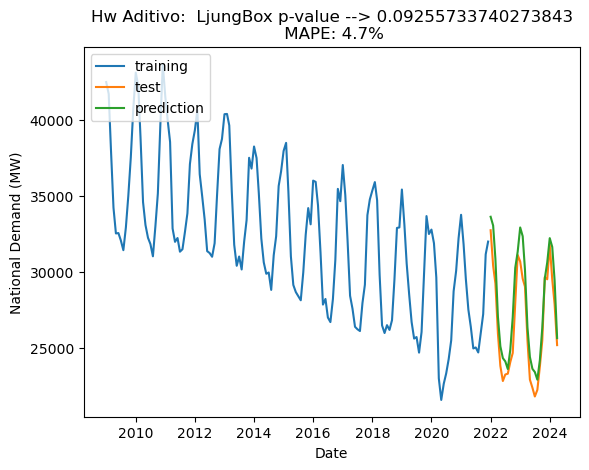

0.09255733740273843


In [18]:
#The function eval_model plots the training, test and prediction to better understand.
#Also gives LjungBox test pvalue to check if the resids are incorrelated.
#Also brings MAPE (Mean Absolute Percentage Error) to measure the difference between reality and prediction
eval_model(hw_add,electricity_training,electricity_test,'Hw Aditivo')

### This plot looks nice, LjungBox gives a pvalue over 0.05, that means the resids are incorrelated, which is condition necessary to be a valid model.

### I still think this MAPE error is too high, we will need to try other models as the ARIMA. As we checked earlier, this model can be applied because the I of ARIMA can differenciate and bring ARMA an stationary serie.

### Appart from that I want to check the resids, because even if the LjungBox test is positive, I want to check them.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

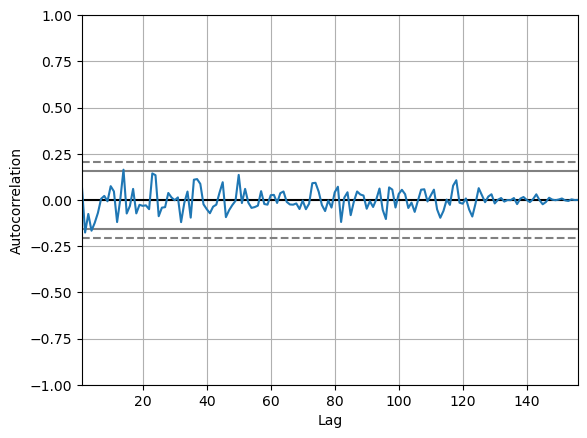

In [19]:
autocorrelation_plot(hw_add.resid)

### The autocorrelation plot of the resids needs to not show any kind of trend, it is also necessary that the errors doesnt move over the upper or lower limits.
### The first errors seems to be at the limit, but, as expected, this model looks valid.

# Step 4 - Second model - SARIMAX

#### SARIMAX model will be used instead of ARIMA because we have seasonality in our serie

## Step 4.1 - Autocorrelation plots

#### In order to check SARIMA order we need to check the autocorrelation plots.
#### To do that we have to first differenciate the serie, make it stationary and then see the autocorrelation plots.

In [20]:
#For the elimination of the trend, we first differnciate with period = 1, to substract the day to the previous one
electricity_diff_1 = electricity["nd"].diff(periods=1)

In [21]:
#For the elimination of the seasonality, we differenciate with period  = 12, to substract the same day of the same month
#of a previous year
electricity_diff_1_12 = electricity_diff_1.diff(periods=12)

In [22]:
#Lets quickly check if the serie is staionary with another Dickey-Fuller test
print('Results of Dickey-Fuller Test for the differenciate serie:')
dftest = adfuller(electricity_diff_1_12.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Results of Dickey-Fuller Test for the differenciate serie:
Test Statistic   -5.781297e+00
p-value           5.118553e-07
dtype: float64


### Perfect, is stationary, we can now plot the autocorrelation functions

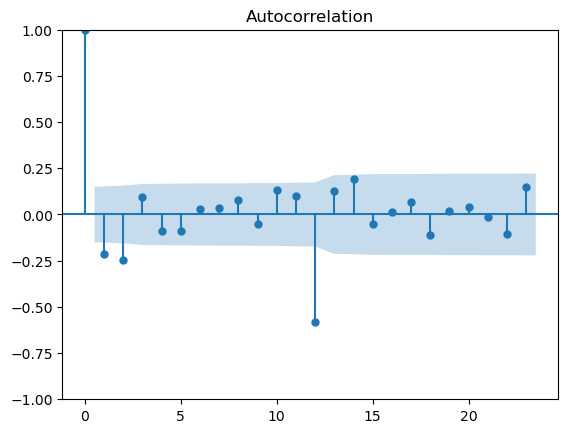

In [23]:
#Autocorrelation function (ACF)
plot_acf(electricity_diff_1_12.dropna(inplace=False))
plt.show()

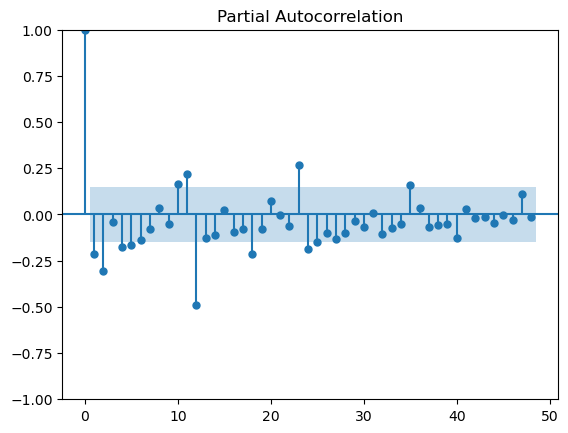

In [24]:
#Partial autocorrelation function (PACF)
plot_pacf(electricity_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

### Judging the autocorrelation and partial autocorrelation we can think about AR = 3 and MA = 3
### But still some kind of seasoning remains due to the 12th, 24th..etc component of both plots. Maybe AR = 4 and MA = 2
### We will try making a 2nd order diff in the seasonality as it looks like it descends slowly in Partial Autocorrelaiton

### Lets make another diff in the seasonality and check again.

In [25]:
electricity_diff_1_12_12 = electricity_diff_1_12.diff(periods=12)

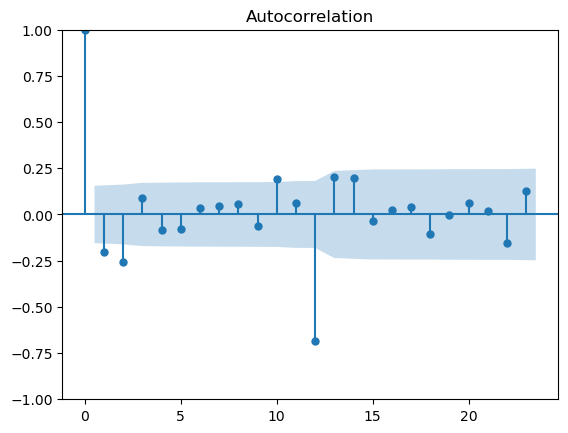

In [26]:
plot_acf(electricity_diff_1_12_12.dropna(inplace=False))
plt.show()

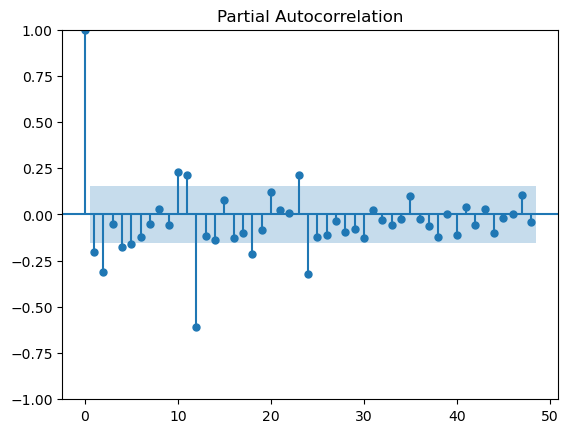

In [27]:
plot_pacf(electricity_diff_1_12_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

### The seasonal component of the Autocorrelation plot looks higher, but i can see slighltly improvements in the seasonal component for the partial autocorrelation

## Step 4.2 - First model - SARIMA with one seasonal diff (3,1,3)(4,1,2)

In [28]:
arima1 = SARIMAX(electricity_training, 
                order = (3, 1, 3), 
                seasonal_order =(4, 1, 2, 12))

C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
arima_1 = arima1.fit()

C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


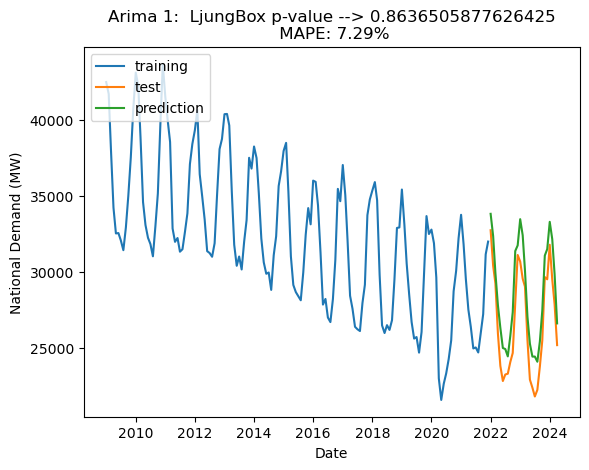

0.8636505877626425


In [30]:
eval_model(arima_1,electricity_training,electricity_test,'Arima 1')

## Step 4.4 - Second model - SARIMA with two seasonal diff (3,1,3)(4,2,2)

C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


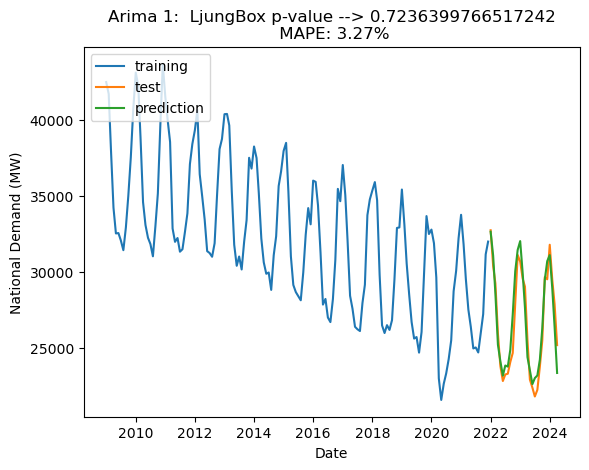

0.7236399766517242


In [31]:
arima1 = SARIMAX(electricity_training, 
                order = (3, 1, 3), 
                seasonal_order =(4, 2, 2, 12))
arima_1 = arima1.fit()
eval_model(arima_1,electricity_training,electricity_test,'Arima 1')

### It is clear the model works better with 2 seasonal diffs, the plot looks more accurate and the MAPE error decreases. 
### This MAPE error is even lower than the error obtained using the previous smoothing technique, which is great

### Now lets check the resids

C:\Users\adrag\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


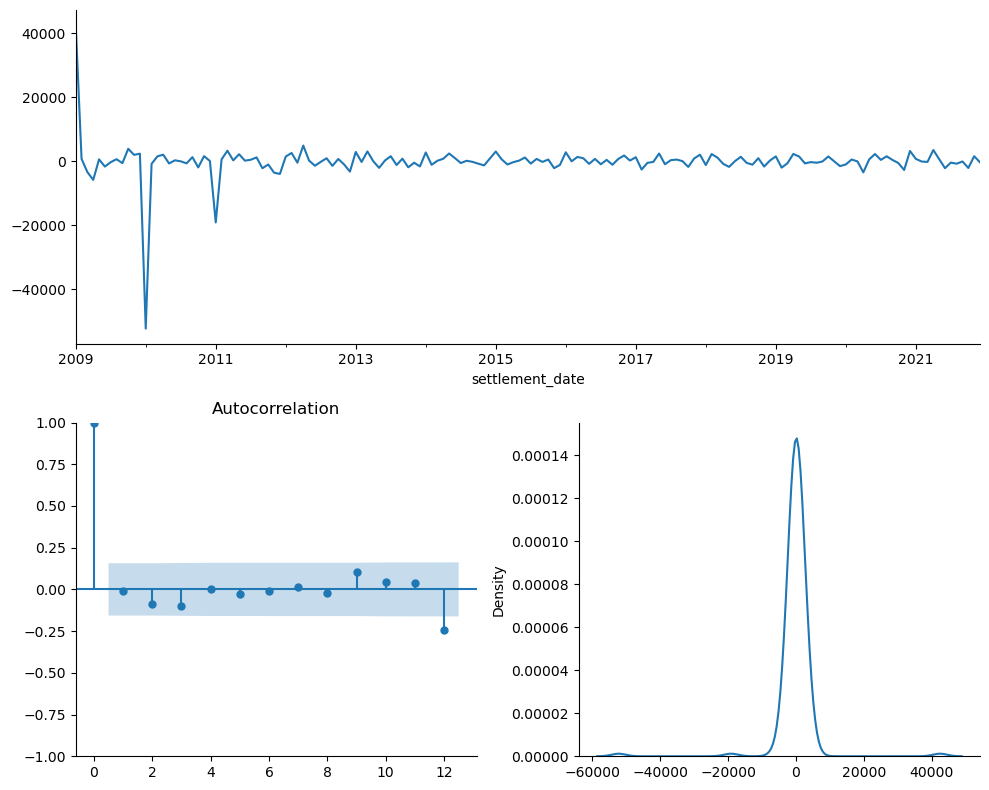

** Mean of the residuals:  -73.94

** Ljung Box Test, p-value: 0.724 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='settlement_date'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [32]:
#residcheck function shows distribution of errors along time, distribution in frecuency and autocorrelation plot.
#It also gives mean of the resids, Jarque-Bera test for Normality, LjungBox test for correlation and Dickey-fuller test for stationarity
residcheck(arima_1.resid,12)

### As we can see, even if the mean of the residuals is not 0 and the Jarque Bera Normality test says the residuals doesnt follow a normal distribution, the truth is that Ljung Box says residuals are incorrelated and AD Fuller says the residuals are stationary, so it's enaguh to declare this model as a valid model.

### Appart from that, as visually the plot looks more accurate than other tecnhiques, and taking into account that MAPE error is the lowest, we will consider this SARIMA as the final model

## Step 5 - Predictions for the rest of 2024

### Taking into account the objetive for this proyect, the prediction for the following months in 2024 will be done

In [33]:
#Creation of the months of 2024
data2024 = ["2024-05","2024-06","2024-07","2024-08","2024-09","2024-10","2024-11","2024-12"]

In [34]:
data2024 = pd.DataFrame(data2024)

In [35]:
data2024.columns = {"Date"}

In [36]:
data2024["Date"] = pd.to_datetime(data2024["Date"])

In [37]:
#Join again the previous training and test
electricity_final = pd.concat([electricity_training, electricity_test], axis=0)

### We need to instantiate the model again and fit-train it with the whole data, just to make sure the predictions are for the remaining months of 2024

In [38]:
arima_final = SARIMAX(electricity_final, 
                order = (3, 1, 3), 
                seasonal_order =(4, 2, 2, 12))
arima_final = arima_final.fit()

C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\adrag\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


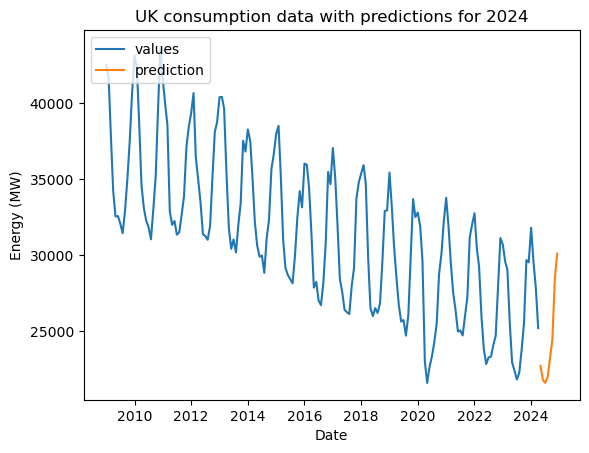

In [39]:
pred = arima_final.forecast(steps=len(data2024["Date"]))
fig1, ax = plt.subplots()
ax.plot(electricity_final, label='values')
ax.plot(pred, label='prediction')
plt.legend(loc='upper left')
plt.title("UK consumption data with predictions for 2024")
plt.ylabel('Energy (MW)')
plt.xlabel('Date')
plt.show()

## Step 6 - Analysis of the predictions - Insights

### As data scientists it is not enaugh with just creating the model, we need to bring insights to our costumers, it will help everyone understand the data and take better decisions with the information

In [40]:
#Convert the previous predictions into Dataframe
pred = pd.DataFrame(pred)

In [41]:
pred.index = pd.to_datetime(pred.index)

In [42]:
pred.columns = {"nd"}

In [43]:
df_join = pd.concat([electricity_final, pred], axis=0)

### Lets first plot a seasonal plot, showing all years

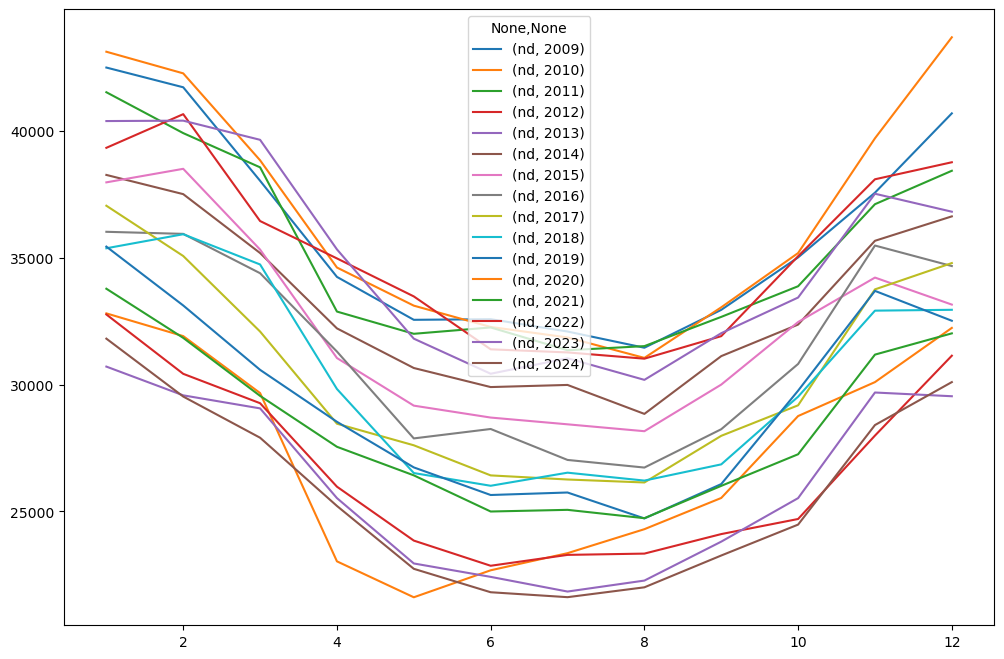

In [44]:
seasonal_plot(df_join)

### Here we can see the trend decreasing every year and the seasonality. More consuption in winter and less in summer. It can be normal as people need to warm their house.
### In color brown is year 2024, predicted values from month 5 forward.

### Its interesting to see how in May 2020, due to the pandemic, the consumption dropped down to the minimum historic level, lets quantify it.

In [45]:

electricity.loc[electricity["settlement_date"] =="2020-05"]

,settlement_date,nd
136,2020-05-01,21610.885081


### That is the historic minimum, 21610 MW of consumption, it eventually recovered and followed the trend more or less in August

### Lets now check the predictions

In [46]:
pred.sort_values(by = "nd")

,nd
2024-07-01,21614.848566
2024-06-01,21809.530389
2024-08-01,22003.543662
2024-05-01,22733.019942
2024-09-01,23258.146285
2024-10-01,24476.681159
2024-11-01,28402.249840
2024-12-01,30095.778299


### The minimum expected consume is in July with 21614 MW. The maximum looks to be in December, with 30095 MW.
### In comparison with the previous year 2023, consumption is expected to follow the trend and be lower for the rest of the year, except for December, that will overcome December - 2023 in consumption